# Build Regression Model To Predict Forward Return. 

In [42]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
import shap, optuna 
from optuna import visualization as opt_viz 
from sklearn.model_selection import TimeSeriesSplit, train_test_split 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import ElasticNet 
from sklearn.metrics import recall_score, classification_report 

# Change the current directory from (./notebook) to root directory. 
while not re.match(r".+MADS-CAP$", os.getcwd()): 
	os.chdir("..") 
	
print(f"Current directory: ({os.getcwd()})") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules.processor_estim import ColumnSelector, multiverse_analysis_classification  
from source.modules import visualizer 

# Custom configs. 
from source.config_py.config import (
	DIR_DATASET_CONSOLIDATED, DIR_DATASET_UTIL, 
	DIR_MLMODEL_MLESTIM, DIR_MLMODEL_MLPERFORMANCE, 
	TICKER_TO_EXCLUDE, TICKER_DATE_COLLECT, PARAM_SEED, 
) 

Current directory: (/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_697_/submission/MADS-CAP)


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 100, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# # Uncomment this part to use Jeremy's stock pick. 
ticker_to_collect = set(manage_files.load_cache_pk(DIR_DATASET_UTIL, "jeremy_tickers_v1.pickle")) 
ticker_to_collect = ticker_to_collect.difference(TICKER_TO_EXCLUDE) 

# # Uncomment this to specify specific tickers here. 
ticker_to_collect = set(["AAPL", "AMZN", "TSLA", "JNJ", "BA", "LMT", "JPM", "GS"]) 
ticker = "AAPL" 

# Define the features and target variable. 
targcol = "label_up" 

# For clearing the output. Not important. 
clear_output()

## Load consolidated ticker data. 

In [3]:
filepath = os.path.join(DIR_DATASET_CONSOLIDATED, "consolidated_feature.parquet")
df_feature = pd.read_parquet(filepath) 

# Preview. 
df_feature 

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag1_autolag1,tscore_c2c_lag1_autolag1,return_c2c_lag1_autolag2,tscore_c2c_lag1_autolag2,return_c2c_lag1_autolag3,tscore_c2c_lag1_autolag3,vix_date,vix_open,vix_close,date_quarter,vl_ticker,vl_fiscalDateEnding,vl_eps,vl_eps_continuing,vl_rps,vl_date_quarter,vl_pe,vl_pe_continuing,vl_ps,event_jobs_opening_labor_turnover,event_non_farm_employment_adp_mom,event_non_farm_employment_mom,event_unemployment_claims,event_unemployment_rate,event_avg_hourly_earnings_mom,event_personal_dispensable_income_mom,event_personal_consumption_mom,event_ism_pmi_manufacturer,event_ism_pmi_services,event_chicago_pmi,event_industry_production_mom,event_phil_fed_manufacturer,event_capacity_utilisation,event_manufacturer_new_order_mom,event_manufacturer_new_order_ex_trans_mom,event_retail_sales_ex_auto_mom,event_retail_sales_mom,event_uom_consumer_sentiment,event_producer_ppi_mom,...,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate,rp_ticker,rp_date,rp_relevance,rp_ess,rp_aes,rp_aev,rp_ens,rp_ens_similarity_gap,rp_css,rp_nip,rp_peq,rp_bee,rp_bmq,rp_bam,rp_bca,rp_ber,rp_anl_chg,rp_mcq,techind_ticker,techind_date,techind_macd_MACD,techind_macd_MACD_Hist,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,candle_cdl3blackcrows,candle_cdldarkcloudcover,candle_cdldoji,candle_cdldojistar,candle_cdldragonflydoji,candle_cdlengulfing,candle_cdleveningdojistar,candle_cdleveningstar,candle_cdlhammer,candle_cdlhangingman,candle_cdlharami,candle_cdlinvertedhammer,candle_cdlmorningdojistar,candle_cdlmorningstar,candle_cdlrickshawman,candle_cdlshootingstar,candle_cdltristar
0,1999-11-23,8.44,8.44,8.44,8.44,60000.0,0.0,0.0,TDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-23,21.07,21.00,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1999-11-24,8.44,10.69,8.44,10.50,917700.0,0.0,0.0,TDY,0.244076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-24,20.70,20.26,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1999-11-26,10.50,10.50,10.50,10.50,32700.0,0.0,0.0,TDY,0.000000,NaN,0.244076,NaN,NaN,NaN,NaN,NaN,1999-11-26,20.35,22.33,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1999-11-29,10.62,10.62,9.25,9.25,511000.0,0.0,0.0,TDY,-0.119048,NaN,0.000000,NaN,0.244076,NaN,NaN,NaN,1999-11-29,24.27,23.57,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0
4,1999-11-30,9.38,9.38,8.50,8.81,2424000.0,0.0,0.0,TDY,-0.047568,NaN,-0.119048,NaN,0.000000,NaN,0.244076,NaN,1999-11-30,23.81,24.18,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Preprocess ticker data. 

### Visualize the label distribution. 

Text(0.5, 1.0, 'tscore_c2c_lag1')

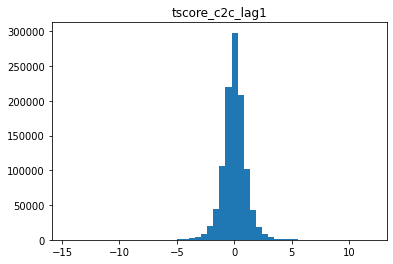

In [4]:
df_feature[targcol].value_counts() 

### Preprocessing steps go here... 

In [5]:
# Filter by ticker. 
boo_ticker = df_feature["ticker"] == ticker 

# Filter by date. 
df_feature["date"] = pd.to_datetime(df_feature["date"], infer_datetime_format=True) 
boo_date = df_feature["date"].dt.year >= 2000 

# Filter. 
df_feature_proc = df_feature[boo_ticker & boo_date].copy() 

# Preview. 
df_feature_proc

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag1_autolag1,tscore_c2c_lag1_autolag1,return_c2c_lag1_autolag2,tscore_c2c_lag1_autolag2,return_c2c_lag1_autolag3,tscore_c2c_lag1_autolag3,vix_date,vix_open,vix_close,date_quarter,vl_ticker,vl_fiscalDateEnding,vl_eps,vl_eps_continuing,vl_rps,vl_date_quarter,vl_pe,vl_pe_continuing,vl_ps,event_jobs_opening_labor_turnover,event_non_farm_employment_adp_mom,event_non_farm_employment_mom,event_unemployment_claims,event_unemployment_rate,event_avg_hourly_earnings_mom,event_personal_dispensable_income_mom,event_personal_consumption_mom,event_ism_pmi_manufacturer,event_ism_pmi_services,event_chicago_pmi,event_industry_production_mom,event_phil_fed_manufacturer,event_capacity_utilisation,event_manufacturer_new_order_mom,event_manufacturer_new_order_ex_trans_mom,event_retail_sales_ex_auto_mom,event_retail_sales_mom,event_uom_consumer_sentiment,event_producer_ppi_mom,...,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate,rp_ticker,rp_date,rp_relevance,rp_ess,rp_aes,rp_aev,rp_ens,rp_ens_similarity_gap,rp_css,rp_nip,rp_peq,rp_bee,rp_bmq,rp_bam,rp_bca,rp_ber,rp_anl_chg,rp_mcq,techind_ticker,techind_date,techind_macd_MACD,techind_macd_MACD_Hist,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,candle_cdl3blackcrows,candle_cdldarkcloudcover,candle_cdldoji,candle_cdldojistar,candle_cdldragonflydoji,candle_cdlengulfing,candle_cdleveningdojistar,candle_cdleveningstar,candle_cdlhammer,candle_cdlhangingman,candle_cdlharami,candle_cdlinvertedhammer,candle_cdlmorningdojistar,candle_cdlmorningstar,candle_cdlrickshawman,candle_cdlshootingstar,candle_cdltristar
990366,2000-01-03,0.80,0.86,0.78,0.85,535796800.0,0.0,0.0,AAPL,0.089744,2.134097,0.012987,0.216937,0.000000,-0.110996,0.026667,0.565073,2000-01-03,24.36,24.21,2000-03-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112.0,5.45,7.8,8.21,8.50,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,2000-01-03,0.0195,0.0003,0.0192,0.7743,NaN,NaN,64.0389,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
990367,2000-01-04,0.83,0.84,0.77,0.78,512377600.0,0.0,0.0,AAPL,-0.082353,-2.163551,0.089744,2.134097,0.012987,0.216937,0.000000,-0.110996,2000-01-04,24.94,27.01,2000-03-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112.0,5.45,7.8,8.21,8.50,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,2000-01-04,0.0181,-0.0009,0.0190,0.7751,NaN,NaN,55.1429,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
990368,2000-01-05,0.79,0.84,0.79,0.79,778321600.0,0.0,0.0,AAPL,0.012821,0.211424,-0.082353,-2.163551,0.089744,2.134097,0.012987,0.216937,2000-01-05,27.98,26.41,2000-03-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112.0,5.45,7.8,8.21,8.50,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,2000-01-05,0.0177,-0.0010,0.0187,0.7769,NaN,NaN,56.1615,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
990369,2000-01-06,0.81,0.82,0.73,0.73,767972800.0,0.0,0.0,AAPL,-0.075949,-1.989399,0.012821,0.211424,-0.082353,-2.163551,0.089744,2.134097,2000-01-06,26.68,25.73,2000-03-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112.0,5.45,7.8,8.21,8.50,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,2000-01-06,0.0117,-0.0056,0.0173,0.7719,NaN,NaN,49.1173,NaN,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0
990370,2000-01-07,0.74,0.77,0.73,0.76,460734400.0,0.0,0.0,AAPL,0.041096,0.923836,-0.075949,-1.989399,0.012821,0.211424,-0.082353,-2.163551,2000-01-07,25.14,21.72,2000-03-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112.0,5.45,7.8,8.21,8.50,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,2000-01-07,0.0097,-0.0061,0.0

## Develop models. 

### Split train test. 

In [6]:
# Get all the target variables (at different lag). 
targetcols = [c for c in df_feature.columns if re.match(r"\w+_c2c_lag\d{1,4}$", c)] + ["label_up"] 

# # Uncomment this to use this to explore all independant variables. 
usecols = df_feature.columns.difference(targetcols) 

# Define the training and label dataset. 
X, y = df_feature_proc.loc[:, usecols], df_feature_proc.loc[:, targcol] 
print("SHAPE:", X.shape) 

SHAPE: (5574, 147)


In [7]:
# # Train test split. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=PARAM_SEED, shuffle=True) 

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(4459, 147) (1115, 147) (4459,) (1115,)


In [8]:
# Train test timeseries split. 

train_size = .8 
split_frm = int(X.shape[0] * train_size) 
X_train, y_train = X.iloc[:split_frm], y.iloc[:split_frm] 
X_test, y_test = X.iloc[split_frm:], y.iloc[split_frm:] 
print("SHAPE:", X_train.shape) 
print("SHAPE:", X_test.shape) 

# For storing all the k-fold splits for cross-validation during model training. 
timeseries_cv = [] 

# Perform the k-fold splits. 
timeseries_split = TimeSeriesSplit(n_splits=10) 

for train_index, test_index in timeseries_split.split(X_train): 
	timeseries_cv.append((train_index, test_index)) 
	print("TRAIN:", len(train_index), "| TEST:", len(test_index)) 

In [ ]:
df_performances = manage_files.load_cache_pk(dirpath=DIR_MLMODEL_MLPERFORMANCE, filename="regression_performance.pickle") 

# Assign direction as class labels for meta-labelling later if needed. 
df_predicted = pd.DataFrame({"estimated": predicted, "label": y_train.values}) 
df_predicted["estimated_up"] = 0 
df_predicted.loc[df_predicted["estimated"] > 0, "estimated_up"] = 1 
df_predicted["label_up"] = 0 
df_predicted.loc[df_predicted["label"] > 0, "label_up"] = 1 

# Confusion matrix. 
pd.crosstab(index=df_predicted["estimated_up"], columns=df_predicted["label_up"]) 

# Preview. 
df_performances 

### Multiverse Analysis. 

In [9]:
# Use this explore selected independant variables. 
use_features = [
	{
		"autocorr": [
			"tscore_c2c_lag1_autolag1",
			"tscore_c2c_lag1_autolag2",
			"tscore_c2c_lag1_autolag3",
		] 
	},
]

In [10]:
# Uncomment this part if you want to rerun the multiverse analysis. 
# Take about 90 minutes to run 50 trials. 50 minutes for 25 trials. 
# SearchCV will automatically stops running the trial if the 
# optimisation reaches a plateau. 

# Perform multiverse analysis. 
df_performances = multiverse_analysis(
	X_train, y_train, cv=timeseries_cv, experiment_comps=use_features, 
	n_trials=25, scoring="neg_root_mean_squared_error", verbose=0
) 

# The scoring method is negative RMSE so we need to "absolute" it. 
df_performances["rmse_avg"] = df_performances["rmse_avg"].abs() 
df_performances = df_performances.sort_values(["rmse_avg", "rmse_std"], ascending=False, ignore_index=True) 

# Compute the interval range. 
df_performances["rmse_intv0025"] = df_performances["rmse_avg"] - (df_performances["rmse_std"] * 2) 
df_performances["rmse_intv0975"] = df_performances["rmse_avg"] + (df_performances["rmse_std"] * 2) 

# Preview. 
df_performances 

,est_names,estimator,component,rmse_avg,rmse_std,ml_n_comp,feat_name,rmse_intv0025,rmse_intv0975
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.018858,0.035347,xgb + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.948163,1.089553
1,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.015554,0.032953,rfr + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.949648,1.081460
2,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.013870,0.032066,els + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.949737,1.078003


In [11]:
# Save the regression model performance record. 
manage_files.save_cache_pk(dirpath=DIR_MLMODEL_MLPERFORMANCE, filename="regression_performance.pickle", object=df_performances) 

# Load the past regression model performance record. 
df_performances = manage_files.load_cache_pk(dirpath=DIR_MLMODEL_MLPERFORMANCE, filename="regression_performance.pickle") 

# Preview. 
df_performances 

Save to (regression_performance.pickle)
Load from (regression_performance.pickle)


,est_names,estimator,component,rmse_avg,rmse_std,ml_n_comp,feat_name,rmse_intv0025,rmse_intv0975
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.018858,0.035347,xgb + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.948163,1.089553
1,rfr,"XGBRFRegressor(base_score=0.5, booster='gbtree...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.015554,0.032953,rfr + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.949648,1.081460
2,els,"ElasticNet(alpha=1, max_iter=5000, random_stat...","{'autocorr': ['tscore_c2c_lag1_autolag1', 'tsc...",1.013870,0.032066,els + {'autocorr': ['tscore_c2c_lag1_autolag1'...,"[tscore_c2c_lag1_autolag1, tscore_c2c_lag1_aut...",0.949737,1.078003


In [12]:
usecols = ["rmse_avg", "ml_n_comp", "rmse_intv0025", "rmse_intv0975"] 
visualizer.plot_multiverse_analysis(df_performances[usecols], x="rmse_avg", y="ml_n_comp", err_minmax=("rmse_intv0025", "rmse_intv0975")) 

alt.LayerChart(...)

### Rebuild the model selecting the approach. 

In [13]:
index = 1 

# Get the feature from the top performing model. 
usecols = df_performances.loc[index, "feat_name"] 

# Get the best estimator. 
estimator = df_performances.loc[index, "estimator"] 

# Model pipeline setup. 
mlpipe_estim = Pipeline([
	("select_col", ColumnSelector(var_proc=usecols)), 
]) 

X_train_feature = mlpipe_estim.fit_transform(X_train) 

# Clear safe warnings. Not important. 
clear_output() 

# Convert to dataframe. 
df_features = pd.DataFrame(X_train_feature, columns=mlpipe_estim["select_col"].get_feature_names_out()) 

# Preview. 
df_features 

,tscore_c2c_lag1_autolag1,tscore_c2c_lag1_autolag2,tscore_c2c_lag1_autolag3
991716,-0.486130,0.872709,0.550651
995910,0.081357,0.987583,-0.075516
991534,2.163422,0.692981,1.536492
995917,-0.359804,-0.876758,-0.726447
995686,-0.226350,-0.124074,-1.082232
...,...,...,...
994138,-1.002211,-0.173226,1.194743
995557,-0.083893,0.181618,-0.231987
995592,-0.149797,0.487517,-1.133177
995756,0.760636,-0.633205,0.193871


In [14]:
# # Uncomment this part if you wanna use this. 

# # Elastic Net. We assume to have many low coefficient features, so 
# # L2 penalty would be more appropriate for regularization in out case 
# # if it is needed. 
# estimator_els = ElasticNet(alpha=1, l1_ratio=.5, max_iter=5000, random_state=PARAM_SEED) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "l1_ratio"  : [.5, .3, .1], 
# } 

# searchres = search_opt(estimator_els, X_train_feature, y_train, param_dist, bayes=False, n_trials=100, verbose=0) 

In [15]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/latest/parameter.html 
# ''' 

# # XGBoost. 
# estimator_xgb = xgb.XGBRegressor(
# 	learning_rate=0.001, n_estimators=100, max_depth=8, base_score=0.5, 
#     reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05, min_child_weight=1, 
#     subsample=0.5, tree_method="auto", booster="gbtree", num_parallel_tree=2, 
#     objective="reg:squarederror", eval_metric="rmse", seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "learning_rate"     : optuna.distributions.LogUniformDistribution(1e-4, 1e-2), 
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_xgb, X_train_feature, y_train, param_dist, n_trials=50, verbose=0) 

In [16]:
# # Uncomment this part if you wanna use this. 

# '''
# Documentation and tutorials: 
#     - https://xgboost.readthedocs.io/en/stable/tutorials/rf.html 
# ''' 

# # Standalone Random Forest API. 
# estimator_rfr = xgb.XGBRFRegressor(
# 	learning_rate=1, n_estimators=100, max_depth=8, base_score=0.5, 
#     colsample_bynode=.5, reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05,
#     min_child_weight=1, subsample=0.5, tree_method="auto", booster="gbtree", 
#     num_parallel_tree=2, objective="reg:squarederror", eval_metric="rmse", 
#     seed=PARAM_SEED, 
# ) 

# # Hyperparameter optimisation setup. 
# param_dist = {
#     "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
#     "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
#     "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
# }

# searchres = search_opt(estimator_rfr, X_train_feature, y_train, param_dist, n_trials=1, verbose=0) 

### Model evaluation. 

In [17]:
# # Assign the best estimator if you retrain the model again. 
# estimator = searchres.best_estimator_ 

# Make prediction. 
base_score = y_train.mean() 
predicted = estimator.predict(X_train_feature) 

# Compare the prediction score. 
base_rmse = np.sqrt( mean_squared_error(y_train, [base_score] * len(y_train), squared=True) ) 
pred_rmse = np.sqrt( mean_squared_error(y_train, predicted, squared=True) ) 

print("Base RMSE: ", base_rmse) 
print("Pred RMSE: ", pred_rmse) 

Base RMSE:  1.0140426431362757
Pred RMSE:  1.007258502862084


In [18]:
df_predicted = pd.DataFrame(data={"true": y_train, "pred": predicted}) 
df_predicted.corr(method="pearson") 

,true,pred
true,1.000000,0.186862
pred,0.186862,1.000000


In [19]:
visualizer.plot_correlation(df_predicted, x="pred", y="true", xlim=(0,4), ylim=(0,4)) 

alt.LayerChart(...)

### Class label evaluation. 

In [45]:
# Assign direction as class labels for meta-labelling later if needed. 
df_predicted = pd.DataFrame({"estimated": predicted, "label": y_train.values}) 
df_predicted["estimated_up"] = 0 
df_predicted.loc[df_predicted["estimated"] > 0, "estimated_up"] = 1 
df_predicted["label_up"] = 0 
df_predicted.loc[df_predicted["label"] > 0, "label_up"] = 1 

# Confusion matrix. 
pd.crosstab(index=df_predicted["estimated_up"], columns=df_predicted["label_up"]) 

label_up,0,1
estimated_up,,
0,1564,1229
1,748,918


In [46]:
# Get the classification report. 
report = classification_report(df_predicted["label_up"], df_predicted["estimated_up"]) 

print(report) 

              precision    recall  f1-score   support

           0       0.56      0.68      0.61      2312
           1       0.55      0.43      0.48      2147

    accuracy                           0.56      4459
   macro avg       0.56      0.55      0.55      4459
weighted avg       0.56      0.56      0.55      4459



### Model interpretation. 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


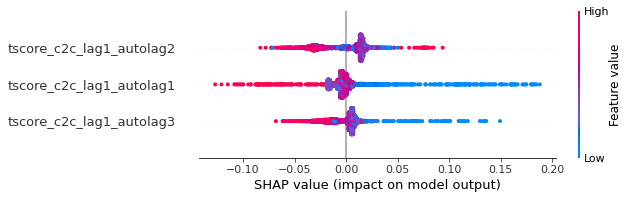

In [20]:
'''
Documentation and tutorials: 
	- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models.html
	- https://github.com/slundberg/shap 
	- https://analyticsindiamag.com/a-complete-guide-to-shap-shapley-additive-explanations-for-practitioners/
'''

explainer = shap.TreeExplainer(estimator) 
shap_values = explainer(df_features) 

# Visualise the feature weight and important for the entire rows. 
shap.plots.beeswarm(shap_values, max_display=20) 

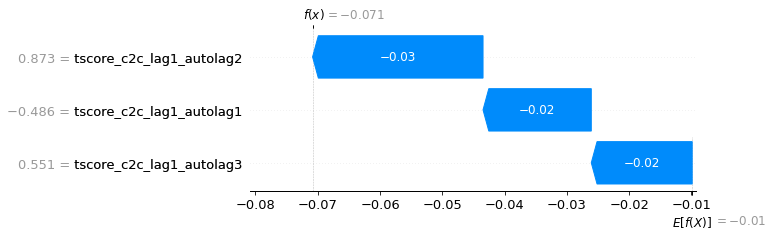

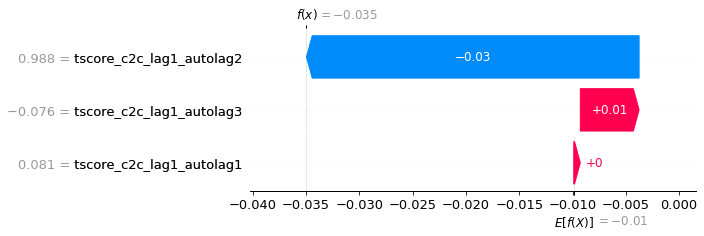

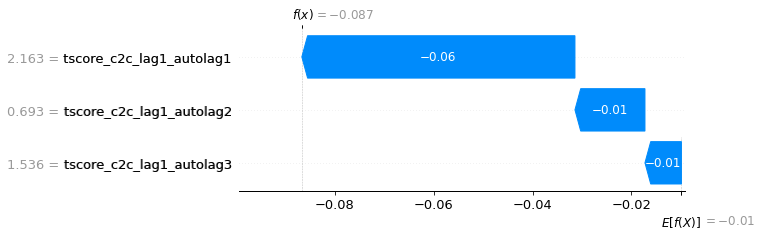

In [21]:
# SHAP. Visualise the feature weight for a single row. 
shap.plots.waterfall(shap_values[0]) 
shap.plots.waterfall(shap_values[1]) 
shap.plots.waterfall(shap_values[2]) 

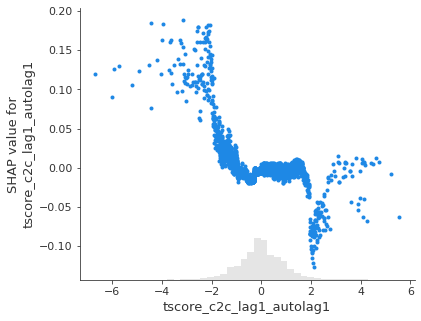

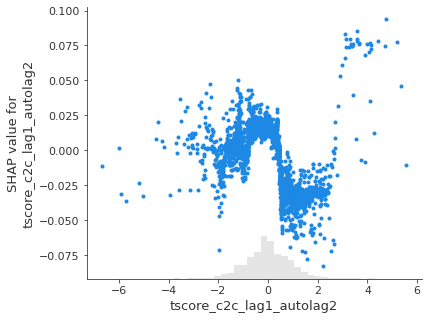

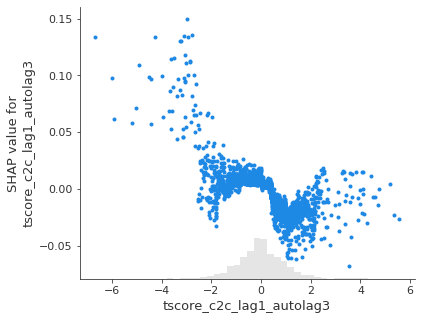

In [22]:
# SHAP. Visualise the feature weight trend for each feature. 
shap.plots.scatter(shap_values[:,0]) 
shap.plots.scatter(shap_values[:,1]) 
shap.plots.scatter(shap_values[:,2]) 

### Save the model. 

In [23]:
# # Cache the model pipeline. 
# mlpipe_name = "mlpipe_estim" 
# manage_files.save_version_pk(dirpath=DIR_MLMODEL_MLESTIM, obj_name=mlpipe_name, object=mlpipe_estim) 
# mlpipe_estim_loaded = manage_files.load_version_pk(dirpath=DIR_MLMODEL_MLESTIM, obj_name=mlpipe_name, version_load="latest") 